In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler

In [ ]:
def preprocessing(df):
    print("Изучение данных датафрейма")
    print("Вывод первых 5 строк \n")
    display(df.head(5))
    print("-" * 100)

    print(f"Размерность датафрейма составляет - {df.shape}")
    print("-" * 100)

    print("Общая информация:\n")
    display(df.info())
    print("-" * 100)

    print("Описательная статистика:\n")
    display(df.describe())
    print("-" * 100)

    # Проверка на наличие пропусков
    print("Проверка на наличие пропусков:\n")
    missing_values = df.isna().sum().sum()
    print(missing_values)
    print("-" * 100)

    print("Проверка на наличие явных дубликатов:\n")
    display(df.duplicated().sum())
    print("-" * 100)

    print("Вывод количества уникальных значений:\n")
    display(pd.DataFrame(df.apply(lambda x: x.nunique())))


In [ ]:
def optimize_memory_usage(df: pd.DataFrame, print_size: bool=True) -> pd.DataFrame:

    '''
    Function optimizes memory usage in dataframe
    print_size: bool - display of optimization results
    return pd.DataFrame - amount of optimized memory
    '''

    # Типы, которые будем проверять на оптимизацию
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    # Размер занимаемой памяти до оптимизации (в Мб)
    before_size = df.memory_usage().sum() / 1024**2
    for column in df.columns:
        column_type = df[column].dtypes
        if column_type in numerics:
            column_min = df[column].min()
            column_max = df[column].max()
            if str(column_type).startswith('int'):
                if column_min > np.iinfo(np.int8).min and column_max < np.iinfo(np.int8).max:
                    df[column] = df[column].astype(np.int8)
                elif column_min > np.iinfo(np.int16).min and column_max < np.iinfo(np.int16).max:
                    df[column] = df[column].astype(np.int16)
                elif column_min > np.iinfo(np.int32).min and column_max < np.iinfo(np.int32).max:
                    df[column] = df[column].astype(np.int32)
                elif column_min > np.iinfo(np.int64).min and column_max < np.iinfo(np.int64).max:
                    df[column] = df[column].astype(np.int64)
            else:
                if column_min > np.finfo(np.float32).min and column_max < np.finfo(np.float32).max:
                    df[column] = df[column].astype(np.float32)
                else:
                    df[column] = df[column].astype(np.float64)

    # Размер занимаемой памяти после оптимизации (в Мб)
    after_size = df.memory_usage().sum() / 1024**2
    if print_size: print('Размер использования памяти: до {:5.2f} Mb - после {:5.2f} Mb ({:.1%})'
                        .format(before_size, after_size, (before_size - after_size) / before_size))

    return df

In [ ]:
def plot_qq_grids(
    df, rows=8, cols=9, figsize=(27, 24), title="Q-Q графики для всех столбцов"
):
    """
    Создает сетку Q-Q графиков для всех числовых столбцов в DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame с данными.
    rows (int): Количество строк в сетке графиков.
    cols (int): Количество столбцов в сетке графиков.
    figsize (tuple): Размер фигуры.
    title (str): Заголовок для всей фигуры.
    """
    # Создание фигуры и осей
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    fig.suptitle(title, fontsize=16)

    # Выбор только числовых столбцов
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    # Итерация по столбцам и построение Q-Q графиков
    for i, col in enumerate(numeric_columns):
        row = i // cols #row вычисляет номер строки, в которой должен находиться график.
        col_pos = i % cols # вычисляет номер столбца для текущего графика.
        ax = axes[row, col_pos]
        stats.probplot(df[col], dist="norm", plot=ax)
        ax.set_title(col, fontsize=10)
        ax.set_xlabel("")
        ax.set_ylabel("")

    # Удаление пустых графиков, если количество столбцов не кратно числу графиков в строке
    for j in range(len(numeric_columns), rows * cols):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout(
        rect=[0, 0, 1, 0.96]
    )  # Подгонка макета и оставление места для основного заголовка
    plt.show()

In [ ]:
# Пути к файлам
pth1 = "./datasets/base.csv"
pth2 = "./datasets/train.csv"
pth3 = "./datasets/validation.csv"
pth4 = "./datasets/validation_answer.csv"

# Функция для загрузки файлов
def load_csv(filepath):
    if os.path.exists(filepath):
        return pd.read_csv(filepath, index_col=0)
    else:
        print(f"File not found: {filepath}")
        return None


# Загрузка данных
df_base = load_csv(pth1)
df_train = load_csv(pth2)
df_validation = load_csv(pth3)
df_validation_answer = load_csv(pth4)


In [ ]:
# Стандартизация названий колонок и оптимизация объема данных
for df in [df_base, df_train, df_validation, df_validation_answer]:
    df.columns = df.columns.str.lower()
    df = optimize_memory_usage(df)

del df

Размер использования памяти: до 162.52 Mb - после 82.38 Mb (49.3%)
Размер использования памяти: до  5.65 Mb - после  2.90 Mb (48.6%)
Размер использования памяти: до  5.57 Mb - после  2.82 Mb (49.3%)
Размер использования памяти: до  0.15 Mb - после  0.15 Mb (0.0%)


In [ ]:
preprocessing(df_base)

Изучение данных датафрейма
Вывод первых 5 строк 



,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
4207931-base,-43.946243,15.364378,17.515854,-132.311462,157.064423,-4.069252,-340.630859,-57.550140,128.398224,45.090958,...,-71.927170,30.711966,-90.190475,-24.931271,66.972534,106.346634,-44.270622,155.988342,-1074.464844,-25.066608
2710972-base,-73.004890,4.923342,-19.750746,-136.529083,99.907173,-70.709106,-567.401978,-128.890152,109.914986,201.472198,...,-109.044662,20.916021,-171.201385,-110.596848,67.730103,8.909615,-9.470253,133.295364,-545.897034,-72.913231
1371460-base,-85.565567,-0.493598,-48.374817,-157.985016,96.809509,-81.710213,-22.297688,79.768669,124.357086,105.715179,...,-58.821651,41.369606,-132.934494,-43.016838,67.871925,141.778244,69.048523,111.720383,-1111.038818,-23.087206
3438601-base,-105.564087,15.393871,-46.223934,-158.114883,79.514114,-48.944481,-93.713013,38.581398,123.397957,110.324326,...,-87.907288,-58.806870,-147.794800,-155.830231,68.974754,21.397511,126.098785,139.733200,-1282.707275,-74.527939
422798-base,-74.638878,11.315012,-40.204174,-161.764297,50.507114,-80.775558,-640.923462,65.224998,122.344940,191.465851,...,-30.002094,53.642929,-149.823227,176.921371,69.473282,-43.395180,-58.947716,133.840637,-1074.464844,-1.164146


----------------------------------------------------------------------------------------------------
Размерность датафрейма составляет - (291813, 72)
----------------------------------------------------------------------------------------------------
Общая информация:

<class 'pandas.core.frame.DataFrame'>
Index: 291813 entries, 4207931-base to 274130-base
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       291813 non-null  float32
 1   1       291813 non-null  float32
 2   2       291813 non-null  float32
 3   3       291813 non-null  float32
 4   4       291813 non-null  float32
 5   5       291813 non-null  float32
 6   6       291813 non-null  float32
 7   7       291813 non-null  float32
 8   8       291813 non-null  float32
 9   9       291813 non-null  float32
 10  10      291813 non-null  float32
 11  11      291813 non-null  float32
 12  12      291813 non-null  float32
 13  13      291813 non-null  float32


None

----------------------------------------------------------------------------------------------------
Описательная статистика:



,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,...,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000,291813.000000
mean,-86.274734,8.078087,-44.613483,-146.605530,111.261185,-71.875023,-393.430481,20.391975,123.676727,124.427147,...,-79.075195,33.244843,-154.720276,13.699276,67.792664,23.543148,74.890038,115.611366,-798.355225,-47.701336
std,24.918947,4.949495,38.545929,19.842726,46.350082,28.189743,272.084930,64.297195,6.352832,64.366631,...,30.485073,28.896143,41.217567,98.996414,1.825081,55.353031,61.320347,21.219221,385.414337,41.731026
min,-189.356018,-12.594500,-231.785919,-224.880493,-95.240829,-188.473328,-791.468750,-296.171051,93.684616,-143.499603,...,-214.821136,-85.825500,-346.239319,-157.593872,59.835789,-213.492416,-190.483154,18.601448,-1297.924927,-209.935760
25%,-103.154297,4.709408,-69.535896,-159.882736,80.367638,-91.227936,-631.937866,-22.085905,119.473625,81.685608,...,-98.823830,16.952824,-180.695557,-71.763962,66.582787,-12.501141,33.784821,101.675659,-1074.464844,-75.621109
50%,-86.308128,8.040010,-43.838493,-146.717361,111.776871,-71.751823,-424.306915,20.850153,123.882500,123.456268,...,-78.538177,34.682541,-153.902832,13.167371,67.815048,23.461630,74.876984,116.049271,-1074.464844,-48.403816
75%,-69.254616,11.466815,-19.694052,-133.320145,142.364609,-52.310825,-157.342697,63.989326,127.967766,167.014130,...,-58.638412,52.097710,-127.221359,99.362213,69.028801,59.740337,115.896881,129.625946,-504.291168,-19.684170
max,15.574615,28.751917,151.377075,-55.167892,299.307922,49.880882,109.631989,301.094238,147.870911,402.994598,...,48.822197,141.025269,17.344528,185.096725,75.474625,264.347198,319.601044,213.577255,98.770813,126.973221


----------------------------------------------------------------------------------------------------
Проверка на наличие пропусков:

0
----------------------------------------------------------------------------------------------------
Проверка на наличие явных дубликатов:



11278

----------------------------------------------------------------------------------------------------
Вывод количества уникальных значений:



,0
0,256118
1,257296
2,257709
3,252056
4,256764
...,...
67,257894
68,257492
69,254869
70,160803


In [ ]:
#df_base.hist(figsize=(25,25));

**Q-Q график (квантиль-квантиль график):**

Показывает насколько данные совпадают с нормальным распределением, сравнивая квантиль данных с квантилями нормального распределения.
В Q-Q графике точки должны быть близки к прямой линии, если данные нормально распределены.

In [ ]:
#plot_qq_grids(df_base)

**Вывод**  
В результате анализа датасета с 72 колонками и 291813 строками были получены следующие ключевые моменты:

- Дубликаты: Обнаружено 11278 дубликатов. Рекомендуется провести их удаление для повышения качества анализа и моделирования.
- Пропуски: Пропуски отсутствуют, что позволяет использовать все доступные данные для дальнейшего анализа.
- Типы данных: Все значения числовые и успешно приведены к формату float32, что оптимизирует использование памяти.
- Названия признаков: Признаки без имен, пронумерованные по порядку. Вероятно, данные закодированы, что следует учитывать при интерпретации результатов.
- Стандартизация: Разнообразие диапазонов значений признаков требует стандартизации для улучшения производительности моделей.
- Распределение значений: Большинство признаков имеют распределение, близкое к нормальному. Однако признаки с номерами 6, 21, 25, 33, 44, 59, 65 и 70 имеют отклонения. Рекомендуется рассмотреть возможность их удаления, поскольку недостаток понимания их значимости может усложнить процесс моделирования.

## Посмотрим данные в столбце df_train

In [ ]:
preprocessing(df_train)

Изучение данных датафрейма
Вывод первых 5 строк 



,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,target
Id,,,,,,,,,,,,,,,,,,,,,
109249-query,-24.021454,3.122524,-80.947525,-112.329994,191.090179,-66.903130,-759.626038,-75.284454,120.551491,131.131699,...,-24.601669,-167.760773,133.678513,68.184601,26.317545,11.938202,148.549316,-778.563354,-46.877750,66971-base
34137-query,-82.033577,8.115866,-8.793022,-182.972107,56.645336,-52.597610,-55.720337,130.059250,129.383347,76.202881,...,54.448433,-120.894806,-12.292085,66.608116,-27.997612,10.091335,95.809265,-1022.691528,-88.564705,1433819-base
136121-query,-75.719643,-0.223386,-86.186127,-162.064056,114.320114,-53.394600,-117.261017,-24.857851,124.807800,112.190155,...,-5.609123,-93.029877,-80.997871,63.733383,11.378683,62.932007,130.975388,-1074.464844,-74.861176,290133-base
105191-query,-56.580620,5.093593,-46.943111,-149.039124,112.436432,-76.820511,-324.995636,-32.833107,119.478653,120.074791,...,21.624313,-158.880371,179.597290,69.891357,-33.804955,233.914612,122.868546,-1074.464844,-93.775375,1270048-base
63983-query,-52.725651,9.027046,-92.829651,-113.111008,134.124969,-42.423073,-759.626038,8.261168,119.490227,172.365356,...,13.807772,-208.650040,41.742016,66.522423,41.362930,162.723053,111.261307,-151.162811,-33.831451,168591-base


----------------------------------------------------------------------------------------------------
Размерность датафрейма составляет - (9999, 73)
----------------------------------------------------------------------------------------------------
Общая информация:

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 109249-query to 13504-query
Data columns (total 73 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9999 non-null   float32
 1   1       9999 non-null   float32
 2   2       9999 non-null   float32
 3   3       9999 non-null   float32
 4   4       9999 non-null   float32
 5   5       9999 non-null   float32
 6   6       9999 non-null   float32
 7   7       9999 non-null   float32
 8   8       9999 non-null   float32
 9   9       9999 non-null   float32
 10  10      9999 non-null   float32
 11  11      9999 non-null   float32
 12  12      9999 non-null   float32
 13  13      9999 non-null   float32
 14  14      9999 no

None

----------------------------------------------------------------------------------------------------
Описательная статистика:



,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,...,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000,9999.000000
mean,-85.469574,7.608016,-43.886494,-146.204147,111.979584,-73.679420,-443.890747,21.820551,123.107399,126.418045,...,-81.373940,37.137379,-152.473801,16.533798,67.803513,23.750004,73.254974,115.410515,-708.824829,-48.325314
std,25.986217,4.985728,39.318615,20.309633,47.599873,28.743811,281.494324,66.450439,6.418815,64.858192,...,30.628553,25.391546,41.109707,98.956200,1.875664,54.838215,61.459194,21.641422,405.686493,40.899658
min,-173.032562,-11.560507,-187.292633,-219.724792,-71.243347,-184.962448,-791.443909,-250.681335,99.001770,-113.104599,...,-191.308228,-60.515068,-306.837646,-157.579208,61.339855,-165.361252,-127.017555,34.696030,-1297.871948,-208.276810
25%,-103.445763,4.178606,-69.990780,-160.032883,79.712387,-93.620304,-757.628754,-21.344349,118.787720,81.959694,...,-101.775513,20.369431,-179.337379,-67.498386,66.534668,-12.360923,32.034006,100.510067,-1074.464844,-75.271168
50%,-85.177101,7.592032,-43.009907,-146.576218,112.233475,-74.031082,-517.673340,22.233669,123.002785,126.280350,...,-81.767227,36.944336,-151.394592,16.007952,67.819710,24.146404,73.178337,115.813057,-800.296692,-49.027412
75%,-67.437847,10.989735,-17.223701,-132.675850,144.052643,-54.168715,-203.437622,66.437386,127.499310,169.959885,...,-60.619156,53.901958,-124.285236,101.773979,69.086704,59.301756,113.039341,130.225601,-362.486816,-21.845187
max,5.052292,26.741890,134.859802,-71.194679,297.368622,31.378914,109.632034,261.413422,145.178467,353.214966,...,20.978668,137.559204,-18.955208,185.055847,74.121605,236.385468,304.391785,187.621399,97.787796,111.831955


----------------------------------------------------------------------------------------------------
Проверка на наличие пропусков:

0
----------------------------------------------------------------------------------------------------
Проверка на наличие явных дубликатов:



243

----------------------------------------------------------------------------------------------------
Вывод количества уникальных значений:



,0
0,9688
1,9690
2,9689
3,9677
4,9690
...,...
68,9690
69,9687
70,7488
71,9690


In [ ]:
#df_train.hist(figsize=(25, 25));

In [ ]:
#plot_qq_grids(df_train)

**Вывод**
В результате анализа датасета с 73 колонками и 999 999 строками были получены следующие ключевые моменты:

- Дубликаты: Обнаружено 243 дубликатов. Рекомендуется провести их удаление для повышения качества анализа и моделирования.
- Пропуски: Пропуски отсутствуют, что позволяет использовать все доступные данные для дальнейшего анализа.
- Типы данных: Все значения числовые и успешно приведены к формату float32, что оптимизирует использование памяти. Есть не числовой столбец tsrget содержащий наш целевой признак
- Названия признаков: Признаки без имен, пронумерованные по порядку. Вероятно, данные закодированы, что следует учитывать при интерпретации результатов.
- Стандартизация: Разнообразие диапазонов значений признаков требует стандартизации для улучшения производительности моделей.
- Распределение значений: Большинство признаков имеют распределение, близкое к нормальному. Однако признаки с номерами 6, 21, 25, 33, 44, 59, 65 и 70 имеют отклонения. (как и в общей базе) Рекомендуется рассмотреть возможность их удаления, поскольку недостаток понимания их значимости может усложнить процесс моделирования.




## Посмотрим на df_validation

In [ ]:
preprocessing(df_validation)

Изучение данных датафрейма
Вывод первых 5 строк 



,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
196680-query,-59.383419,8.563437,-28.203072,-134.225342,82.736610,-150.572174,-129.178970,23.670555,125.666359,108.809586,...,-103.481628,79.564529,-120.313568,54.218155,68.500732,32.681908,84.196861,136.412964,-1074.464844,-21.233612
134615-query,-103.912148,9.742726,-15.209915,-116.373100,137.698807,-85.530075,-776.123169,44.481529,114.671211,95.231293,...,-51.193771,49.299644,-101.894539,105.560547,67.801041,13.633057,108.051376,111.864456,-841.022339,-76.567978
82675-query,-117.923279,-3.504554,-64.299393,-155.187134,156.821365,-34.082264,-537.423645,54.078613,121.973961,59.321335,...,-115.176155,48.636131,-132.179672,-0.988696,68.111252,107.065216,134.617645,134.080002,27.773270,-32.401714
162076-query,-90.880554,4.888542,-39.647797,-131.750107,62.362122,-105.593269,-347.132507,-83.351753,133.913315,201.146088,...,-112.293793,54.884007,-177.569351,-116.375000,67.887657,136.893982,124.894470,117.707748,-566.343994,-90.905556
23069-query,-66.946739,10.562773,-73.781830,-149.397873,2.938660,-51.288853,-587.189331,-2.764402,126.561050,131.900620,...,-116.440605,47.279976,-162.654007,107.409409,67.785263,-60.976490,142.685715,82.264297,-345.340454,-48.572525


----------------------------------------------------------------------------------------------------
Размерность датафрейма составляет - (10000, 72)
----------------------------------------------------------------------------------------------------
Общая информация:

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 72 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       10000 non-null  float32
 1   1       10000 non-null  float32
 2   2       10000 non-null  float32
 3   3       10000 non-null  float32
 4   4       10000 non-null  float32
 5   5       10000 non-null  float32
 6   6       10000 non-null  float32
 7   7       10000 non-null  float32
 8   8       10000 non-null  float32
 9   9       10000 non-null  float32
 10  10      10000 non-null  float32
 11  11      10000 non-null  float32
 12  12      10000 non-null  float32
 13  13      10000 non-null  float32
 14  14      10000

None

----------------------------------------------------------------------------------------------------
Описательная статистика:



,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,-85.307365,7.633750,-43.686535,-146.038788,111.209938,-72.767937,-440.587158,21.834860,123.051773,124.662560,...,-81.250175,36.956902,-152.122726,14.886141,67.791824,22.857615,72.524490,115.420799,-709.333496,-49.022259
std,25.911682,4.950078,38.805283,20.543489,47.779449,28.617899,278.953674,66.326515,6.522882,65.458931,...,30.617504,25.251097,40.945221,99.384247,1.851120,55.658493,62.595135,21.490728,405.917480,41.159870
min,-167.550674,-10.583933,-205.797363,-219.720886,-76.422760,-170.868378,-791.443909,-277.983948,97.360535,-118.700714,...,-189.231293,-47.206474,-308.200378,-157.580673,61.086391,-174.799103,-159.840729,27.746750,-1297.689575,-209.935760
25%,-103.253996,4.245802,-69.606606,-159.972973,78.592808,-92.371088,-739.549103,-22.112910,118.623890,81.167942,...,-101.935440,19.950575,-178.986320,-71.481628,66.545755,-14.034863,31.120447,100.431219,-1074.464844,-76.834515
50%,-85.495232,7.604729,-43.152172,-146.100197,111.398598,-72.734219,-512.600708,22.596903,123.105534,124.588371,...,-80.640327,36.343388,-151.159157,16.498258,67.809391,22.756214,71.640041,115.465534,-809.193115,-49.420509
75%,-67.228039,10.950509,-17.883776,-131.973091,143.645966,-53.415469,-204.531445,67.179239,127.583332,168.550243,...,-60.179952,53.856120,-124.446026,100.077341,69.043970,60.188394,114.197411,129.996609,-358.197334,-20.995152
max,10.861183,27.944784,107.040688,-73.909584,287.397186,47.001106,109.404854,251.090179,146.034409,350.088318,...,31.880241,141.025269,-17.406784,184.987274,73.886787,241.695618,289.583160,190.171417,98.747131,102.473755


----------------------------------------------------------------------------------------------------
Проверка на наличие пропусков:

0
----------------------------------------------------------------------------------------------------
Проверка на наличие явных дубликатов:



265

----------------------------------------------------------------------------------------------------
Вывод количества уникальных значений:



,0
0,9667
1,9669
2,9672
3,9661
4,9668
...,...
67,9672
68,9668
69,9668
70,7419


In [ ]:
#df_validation.hist(figsize=(25, 25));

In [ ]:
#plot_qq_grids(df_validation)

**Вывод**
В результате анализа датасета с 72 колонками и 10 000 строками были получены следующие ключевые моменты:

- Дубликаты: Обнаружено 265 дубликатов. Рекомендуется провести их удаление для повышения качества анализа и моделирования.
- Пропуски: Пропуски отсутствуют, что позволяет использовать все доступные данные для дальнейшего анализа.
- Типы данных: Все значения числовые и успешно приведены к формату float32, что оптимизирует использование памяти.
- Названия признаков: Признаки без имен, пронумерованные по порядку. Вероятно, данные закодированы, что следует учитывать при интерпретации результатов.
- Стандартизация: Разнообразие диапазонов значений признаков требует стандартизации для улучшения производительности моделей.
- Распределение значений: Большинство признаков имеют распределение, близкое к нормальному. Однако признаки с номерами 6, 21, 25, 33, 44, 59, 65 и 70 имеют отклонения. (как и в общей базе) Рекомендуется рассмотреть возможность их удаления, поскольку недостаток понимания их значимости может усложнить процесс моделирования.

## Посмотрим на df_validation_answer


In [ ]:
preprocessing(df_validation_answer)

Изучение данных датафрейма
Вывод первых 5 строк 



,expected
Id,
196680-query,1087368-base
134615-query,849674-base
82675-query,4183486-base
162076-query,2879258-base
23069-query,615229-base


----------------------------------------------------------------------------------------------------
Размерность датафрейма составляет - (10000, 1)
----------------------------------------------------------------------------------------------------
Общая информация:

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 196680-query to 43566-query
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   expected  10000 non-null  object
dtypes: object(1)
memory usage: 156.2+ KB


None

----------------------------------------------------------------------------------------------------
Описательная статистика:



,expected
count,10000
unique,9640
top,935520-base
freq,3


----------------------------------------------------------------------------------------------------
Проверка на наличие пропусков:

0
----------------------------------------------------------------------------------------------------
Проверка на наличие явных дубликатов:



360

----------------------------------------------------------------------------------------------------
Вывод количества уникальных значений:



,0
expected,9640


Это наша контрольная таблица, содержит столько же значений что и df_validation, поэтому удалять дубликаты не будем, всегда же может быть что нужно найти пары к одному и тому же товару, ну а ответы конечно могут содержать похожие товары

#Предобработка


In [ ]:
def preprocess_data(df, drop_duplicates=True):
    # Проверка на дубликаты
    if drop_duplicates:
        # Подсчет количества дубликатов до их удаления
        num_duplicates_before = df.duplicated().sum()
        if num_duplicates_before > 0:
            print(f"Обнаружено {num_duplicates_before} дубликатов. Они будут удалены.")
            df = df.drop_duplicates()
            # Подсчет количества дубликатов после удаления
            num_duplicates_after = df.duplicated().sum()
            if num_duplicates_after == 0:
                print("Дубликаты успешно удалены.")
            else:
                print(f"После удаления осталось {num_duplicates_after} дубликатов.")
        else:
            print("Дубликаты не обнаружены.")
    return df

In [ ]:
# Предобработка наборов данных
df_base = preprocess_data(df_base)
df_train = preprocess_data(df_train)
df_validation = preprocess_data(df_validation, drop_duplicates=False)  # Не удаляем дубликаты
df_validation_answer = preprocess_data(df_validation_answer, drop_duplicates=False)  # Не удаляем дубликаты

Обнаружено 11278 дубликатов. Они будут удалены.
Дубликаты успешно удалены.
Обнаружено 243 дубликатов. Они будут удалены.
Дубликаты успешно удалены.


Так как признаки в нашем датасете находятся в разных диапазонах , это может привести к тому, что алгоритм будет неправильно интерпретировать расстояния между точками. В дальнейшем нужно провести поиск ближайших соседей на основе рассчета растояний между векторами, следоательно нам нужно использовать StandardScaler, и с помощью него провести стандартизацию признаков - стандартизация приводит все признаки к единой шкале (среднее 0 и стандартное отклонение 1), что делает расстояния между точками более объективными и корректными.

In [ ]:
from sklearn.preprocessing import StandardScaler

def standardize_data(df):
    # Получение числовых столбцов
    numerical_cols = df.select_dtypes(include=['float64', 'float32', 'int', 'int64']).columns
    scaler = StandardScaler()

    # Проверка, есть ли числовые столбцы для стандартизации
    if len(numerical_cols) > 0:
        df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

        # Проверка успешности стандартизации
        max_mean_deviation = df[numerical_cols].mean().abs().max()
        max_std_deviation = (df[numerical_cols].std() - 1).abs().max()
        if max_mean_deviation < 0.1 and max_std_deviation < 0.1:
            print("Стандартизация прошла успешно.")
        else:
            print("Стандартизация не удалась.")
    else:
        print("Нет числовых столбцов для стандартизации.")

    return df

In [ ]:
# настройка отображения чисел с плавающей точкой
pd.set_option("display.float_format", "{:.3f}".format)

In [ ]:
# Стандартизация
df_base = standardize_data(df_base)
df_train = standardize_data(df_train)
df_validation = standardize_data(df_validation)

Стандартизация прошла успешно.
Стандартизация прошла успешно.
Стандартизация прошла успешно.


In [ ]:
# Удаление колонок с отклонениями
columns_to_remove = [6, 21, 25, 33, 44, 59, 65, 70]
df_base.drop(columns=df_base.columns[columns_to_remove], inplace=True)
df_train.drop(columns=df_train.columns[columns_to_remove], inplace=True)
df_validation.drop(columns=df_validation.columns[columns_to_remove], inplace=True)

In [ ]:
# Вывод размера предобработанных данных
print(f'df_base shape: {df_base.shape}')
print(f'df_train shape: {df_train.shape}')
print(f'df_validation shape: {df_validation.shape}')
print(f'df_validation_answer shape: {df_validation_answer.shape}')

df_base shape: (280535, 64)
df_train shape: (9756, 65)
df_validation shape: (10000, 64)
df_validation_answer shape: (10000, 1)


In [ ]:
!apt -q install libomp-dev -q
!pip -q install faiss-gpu  -q

The following additional packages will be installed:
  libomp-14-dev libomp5-14
Suggested packages:
  libomp-14-doc
The following NEW packages will be installed:
  libomp-14-dev libomp-dev libomp5-14
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 738 kB of archives.
After this operation, 8,991 kB of additional disk space will be used.
Selecting previously unselected package libomp5-14:amd64.
(Reading database ... 123589 files and directories currently installed.)
Preparing to unpack .../libomp5-14_1%3a14.0.0-1ubuntu1.1_amd64.deb ...
Unpacking libomp5-14:amd64 (1:14.0.0-1ubuntu1.1) ...
Selecting previously unselected package libomp-14-dev.
Preparing to unpack .../libomp-14-dev_1%3a14.0.0-1ubuntu1.1_amd64.deb ...
Unpacking libomp-14-dev (1:14.0.0-1ubuntu1.1) ...
Selecting previously unselected package libomp-dev:amd64.
Preparing to unpack .../libomp-dev_1%3a14.0-55~exp2_amd64.deb ...
Unpacking libomp-dev:amd64 (1:14.0-55~exp2) ...
Setting up libomp5-14:amd64 

**Предобработка завершена, данные стандартизированы, столбцы выбивающиеся из нормального распределения удалены можно приступать к настройке алгоритма**

Faiss (Facebook AI Similarity Search) — это библиотека для эффективного поиска похожих векторов в больших наборах данных. Она была разработана в Facebook для обработки огромных объемов данных, таких как изображения или тексты, где необходимо быстро находить близкие векторы по метрике сходства

**Как работает Faiss:**
- Индексация данных: В начале необходимо индексировать набор данных. Faiss создает структуру данных, которая быстро позволяет находить близкие векторы к запросам.

- Поиск похожих векторов: Когда данные проиндексированы, Faiss позволяет выполнять запросы для поиска близких векторов к заданному запросу. Можно указать количество ближайших соседей, которые нужно найти, и Faiss вернет наиболее близкие векторы по выбранной метрике расстояния.

- Оптимизация производительности: Faiss оптимизирован для работы с большими объемами данных и предлагает эффективные алгоритмы для ускорения операций поиска, включая использование GPU и специализированные структуры данных.

Свою работу выполняю на Mac OS, поэтому использую CPU (На CPU доступны те же алгоритмы индексации, что и на GPU, включая IndexFlatL2, IndexIVFFlat, IndexIVFPQ)

IndexFlatL2 является одним из самых простых и прямолинейных индексов в Faiss, который использует L2 (евклидово) расстояние для поиска ближайших соседей. Этот индекс не использует структурированные индексы или квантование, что делает его подходящим для небольших наборов данных или когда требуется высокая точность.

Мы будем использовать **IndexIVFFlat**
IndexIVFFlat является более сложным и эффективным индексом в Faiss, предназначенным для работы с большими наборами данных. Он использует инвертированные файлы (Inverted File Lists, IVF) для ускорения поиска ближайших соседей, разбивая пространство векторов на кластеры и выполняя поиск только в наиболее релевантных кластерах.

Данный индекс нам наиболее подходит ввиду большой базы данных

Для инициализации IndexIVFFlat необходимо использовать квантователь типа IndexFlatL2. Это связано с тем, что IndexFlatL2 является простым индексом, который будет использоваться для создания кластеров при тренировке IndexIVFFlat.

Квантователь (quantizer) — это индекс, который используется для разбиения пространства векторов на кластеры. В основном, квантователь помогает разделить большое количество векторов на меньшие подмножества, что позволяет существенно ускорить процесс поиска ближайших соседей. IndexFlatL2 используется как квантователь для IndexIVFFlat, чтобы создать кластеры на основе евклидова расстояния.

После создания и тренировки кластеров, основной индекс IndexIVFFlat будет использовать эти кластеры для быстрого поиска ближайших соседей.

In [ ]:
import faiss

Для тренировки алгоритма, нужно определиться с тем сколько у нас будет кластеров, и определить в скольки кластерах наш алгоритм будет искать ближайших соседей. При 1 алгоритм ищет только в одном кластере, при большем количестве поиск идет в большем количестве кластеров, увеличивая время поиска, но и повышает точность.
Выбор оптимального значения nprobe зависит от компромисса между точностью и производительностью.

https://www.geeksforgeeks.org/determining-the-number-of-clusters-in-data-mining/ говорит, что оптимально взять  значение примерно √(n/2) для набора данных из n точек
> A simple method to calculate the number of clusters is to set the value to about √(n/2) for a dataset of ‘n’ points.

Однако, код у меня завис с таки большим количеством кластеров, в связи с чем, возьму пока небольшое значение в 20, и проведем поиск по 5 кластерам https://github.com/facebookresearch/faiss/wiki/Faiss-indexes документация говорит о том что чем больше поиск по кластерам тем точнее, в одном из примеров было указано значение 5, его и возьмем для nprobe


Далее планирую использовать метод локтя: для выбора оптимального количества кластеров. Для этого оценим внутреннюю метрику, такую как внутрикластерное расстояние, и выберем количество кластеров на "локте" графика.

In [ ]:
# Извлечение признаков и идентификаторов
#  получение размерности признаков
dims = df_base.shape[1]
#Количество ячеек (кластеров) для индекса IVF.
n_cells = 20
# Инициализация квантователя с L2-нормой.
quantizer = faiss.IndexFlatL2(dims)
#Создание индекса с векторным квантованием (IVF) с указанными параметрами.
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
# Количество кластеров в которых будет проходить поиск
idx_l2.nprobe = 5

In [ ]:
# Случайным образом выбираем 50000 строк из df_base для обучения (для ускорения)
#random_sample = df_base.sample(n=50000, random_state=42)

https://machinelearningapplied.com/fast-gpu-based-nearest-neighbors-with-faiss/
Воспользовалась подсказкой что


> для при использовании массивов Numpy в качестве входных данных для них должно быть задано значение dtype = ‘float32’. Faiss предполагает, что массивы Numpy являются непрерывными. Воспользуйся: ny_array = np.ascontiguousarray(npy_array)

In [ ]:
# Подготовка данных для Faiss
# Преобразуем признаки в формат np.array типа float32, необходимый для Faiss
#random_sample_features = np.ascontiguousarray(random_sample.values).astype('float32')
# Преобразуем данные df_base в формат np.array типа float32 для использования в Faiss
#base_features = np.ascontiguousarray(df_base.values).astype('float32')
base_features = np.ascontiguousarray(df_base.values).astype('float32')

df_base содержит полный набор данных, который представляет все товары, среди которых будет происходить поиск ближайших соседей. Индекс должен содержать все возможные варианты товаров, чтобы при запросе из df_train мы могли правильно найти ближайшие соответствия среди всех товаров. Поэтому используем данные из df_base для создания и тренировки индекса, а  df_train используем для проверки точности поиска ближайших соседей.

In [ ]:
# Тренируем индекс на случайной выборке
#idx_l2.train(random_sample_features)
idx_l2.train(base_features)
# Добавляем основные данные (df_base) в индекс, чтобы индекс знал, какие данные у него есть.
idx_l2.add(base_features)

Создаем словарь, который сопоставляет каждому индексу его идентификатор из столбца id. Это позволит быстро находить идентификаторы по индексам.

In [ ]:
# Создание словаря индексов
base_index = dict(enumerate(df_base.index.to_list()))

In [ ]:
#Сохранение целевых значений и удаление столбца 'target' из df_train
targets = df_train["target"].values

In [ ]:
df_train_features = df_train.drop(["target"], axis=1) # Удаляем столбец 'target' из df_train для подготовки данных к поиску ближайших соседей

In [ ]:
train_features = np.ascontiguousarray(df_train_features.values).astype('float32') # Преобразуем данные df_train в формат np.array типа float32 для использования в Faiss

Используем подготовленные тренировочные данные, чтобы найти 5 ближайших соседей для каждого элемента. distances — это расстояния до соседей, а indices — индексы этих соседей.

In [ ]:
# Поиск ближайших соседей для тренировочных данных
k = 5 # Количество ближайших соседей для поиска
distances, indices = idx_l2.search(train_features, k) # Ищем k ближайших соседей для каждой строки в train_features

In [ ]:
#Проверка качества алгоритма
acc = 0
for target, neighbors in zip(targets, indices): # Проходим по каждому целевому значению и его ближайшим соседям
  acc += int(target in [base_index[r] for r in neighbors]) # Увеличиваем счетчик, если целевое значение присутствует среди соседей



In [ ]:
#Вывод точности
accuracy = 100 * acc / len(indices) # Вычисляем точность в процентах
print(f"Accuracy: {accuracy:.2f}%") # Выводим точность на экран

Accuracy: 77.94%


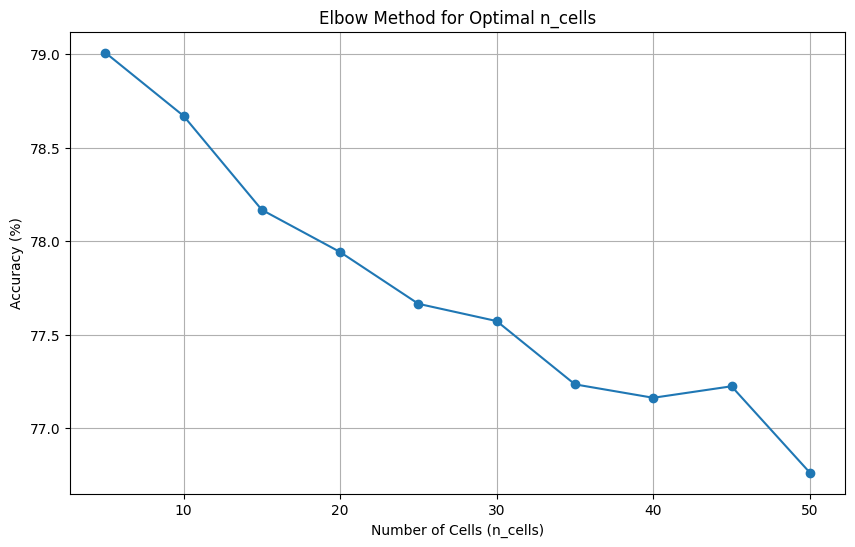

Optimal n_cells: 5
Highest Accuracy: 79.01%


In [ ]:
# Диапазон значений для n_cells
n_cells_range = range(5, 51, 5)
k = 5  # Количество ближайших соседей для поиска

accuracies = []

for n_cells in n_cells_range:
    # Инициализация квантователя с L2-нормой и создание индекса
    quantizer = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
    idx_l2.nprobe = 5

    # Обучение индекса
    idx_l2.train(base_features)
    idx_l2.add(base_features)

    # Поиск ближайших соседей
    distances, indices = idx_l2.search(train_features, k)

    # Оценка точности
    acc = 0
    for target, neighbors in zip(targets, indices):
        acc += int(target in [base_index[r] for r in neighbors])

    accuracy = 100 * acc / len(indices)
    accuracies.append(accuracy)



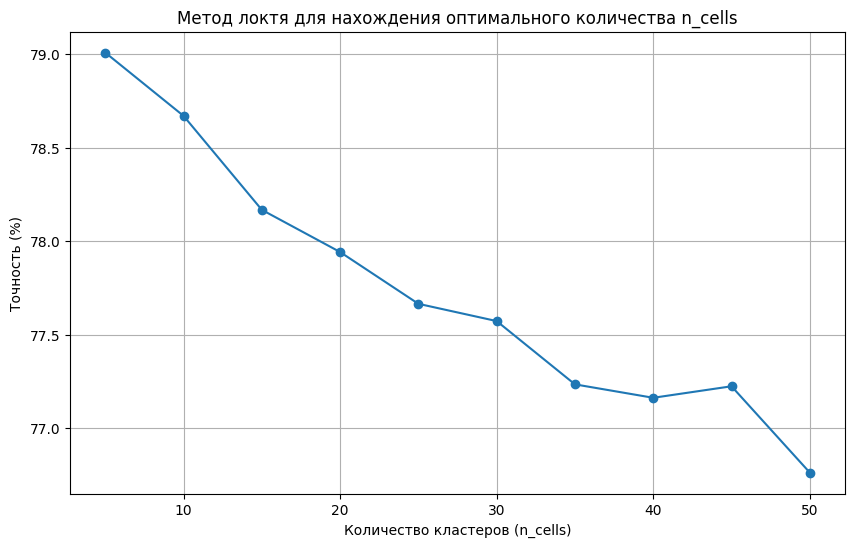

In [ ]:
# Построение графика метода локтя
plt.figure(figsize=(10, 6))
plt.plot(n_cells_range, accuracies, marker='o', linestyle='-')
plt.xlabel('Количество кластеров (n_cells)')
plt.ylabel('Точность (%)')
plt.title('Метод локтя для нахождения оптимального количества n_cells')
plt.grid(True)
plt.show()



In [ ]:
# Вывод лучшего значения n_cells
optimal_n_cells = n_cells_range[np.argmax(accuracies)]
print(f"Оптимальный n_cells: {optimal_n_cells}")
print(f"Точность: {max(accuracies):.2f}%")

Оптимальный n_cells: 5
Точность: 79.01%


In [ ]:
# Определяем размер индексных векторов
dims = df_base.shape[1]

In [ ]:
# Подготовим массив для хранения точностей
n_cells_range = range(5, 51, 5)  # Проверяем от 5 до 50
accuracies = []

In [ ]:
# Запоминаем индексы и целевые значения
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
targets = df_train["target"].values
df_train.drop("target", axis=1, inplace=True)

Number of Clusters: 5, Accuracy: 79.01%
Number of Clusters: 10, Accuracy: 78.67%
Number of Clusters: 15, Accuracy: 78.13%
Number of Clusters: 20, Accuracy: 77.77%
Number of Clusters: 25, Accuracy: 77.48%
Number of Clusters: 30, Accuracy: 77.46%
Number of Clusters: 35, Accuracy: 77.45%
Number of Clusters: 40, Accuracy: 77.08%
Number of Clusters: 45, Accuracy: 77.00%
Number of Clusters: 50, Accuracy: 76.82%


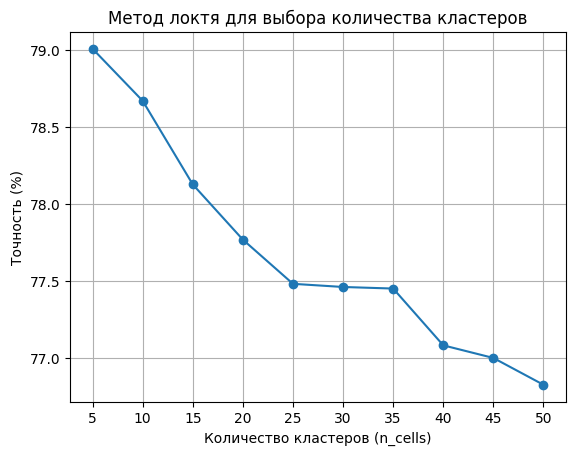

In [ ]:
# Поиск на различных значениях n_cells
for n_cells in n_cells_range:
    # Инициализация квантователя и индекса
    quantizer = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
    #idx_l2.nprobe = 5

    # Берем случайную выборку для обучения
    random_sample = df_base.sample(n=50000, random_state=42)

    # Обучаем индекс и добавляем векторы
    idx_l2.train(np.ascontiguousarray(random_sample.values).astype('float32'))
    idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

    # Находите пятерку ближайших соседей
    r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)

    # Проверяем качество алгоритма
    acc = 0
    for target, neighbors in zip(targets, idx):
        acc += int(target in [base_index[r] for r in neighbors])

    # Рассчитываем и сохраняем точность
    accuracy = 100 * acc / len(idx)
    accuracies.append(accuracy)
    print(f"Number of Clusters: {n_cells}, Accuracy: {accuracy:.2f}%")

# Визуализация результатов
plt.plot(n_cells_range, accuracies, marker='o')
plt.xlabel('Количество кластеров (n_cells)')
plt.ylabel('Точность (%)')
plt.title('Метод локтя для выбора количества кластеров')
plt.xticks(n_cells_range)
plt.grid()
plt.show()

In [ ]:
# Поиск пяти индексов (пяти соседей) для validation из base
r_val, idx_val = idx_l2.search(np.ascontiguousarray(df_validation.values).astype('float32'), 5)

In [ ]:
# Выводим на экран индексы пяти ближайших соседей из base для каждого товара validation
print("Индексы пяти ближайших соседей:")
idx_val

Индексы пяти ближайших соседей:


array([[155542, 163078, 137496,  46202,  56838],
       [  3786, 181149,  63279, 105570, 157572],
       [ 54931, 126599,  97207, 257601,  10671],
       ...,
       [ 65791,  74434, 165218, 238357, 188250],
       [138211,  19848, 251214, 115030,  89556],
       [149533,  46020, 151103, 162028, 122405]])

In [ ]:
# Извлекаем правильные ответы из df_valid_answer
targets_valid = df_validation_answer["expected"].values

In [ ]:
targets_valid

array(['1087368-base', '849674-base', '4183486-base', ..., '3821-base',
       '18068-base', '1197661-base'], dtype=object)

In [ ]:
acc = 0
base_index = dict(enumerate(df_base.index.to_list()))

In [ ]:
# Проверяем качество алгоритма
for target, neighbors in zip(targets_valid, idx_val):
    acc += any(target == base_index[row] for row in neighbors)

In [ ]:
# Определяем размер индексных векторов, равный количеству столбцов в base
dims = df_base.shape[1]

In [ ]:
# Определяем количество кластеров/центроидов
n_cells = 25

In [ ]:
# Инициализируем квантователь
quantizer = faiss.IndexFlatL2(dims)

In [ ]:
# Определяем индекс
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [ ]:
# Устанавливаем количество кластеров для поиска
idx_l2.nprobe = 5

In [ ]:
random_sample = df_base.sample(n=50000, random_state=42)

# Теперь можно использовать random_sample для обучения индекса
idx_l2.train(np.ascontiguousarray(random_sample.values).astype('float32'))

In [ ]:
# Добавляем векторы в кластеры
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [ ]:
# Индексы base переводим в счетчик, начинающийся с нуля
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [ ]:
# Записываем в переменную targets столбец "Target" из train
targets = df_train["target"].values  # Сохраняем значения в массив
df_train.drop("target", axis=1, inplace=True)

In [ ]:
# Находим пять индексов (пять соседей) для train из base
r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)

In [ ]:
# Проверяем качество алгоритма
acc = 0
for target, neighbors in zip(targets, idx):
    acc += int(target in [base_index[r] for r in neighbors])

In [ ]:
# Вывод точности
accuracy = 100 * acc / len(idx)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 77.48%


In [ ]:
# Выводим точность
accuracy = 100 * acc / len(idx_val)
print(f"Accuracy на валидации: {accuracy:.2f}%")

Accuracy на валидации: 76.06%


In [ ]:
# Определяем размер индексных векторов, равный количеству столбцов в base
dims = df_base.shape[1]

In [ ]:
# Определяем количество кластеров/центроидов
n_cells = 25

In [ ]:
# Инициализируем квантователь
quantizer = faiss.IndexFlatL2(dims)

In [ ]:
# Определяем индекс
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [ ]:
# Устанавливаем количество кластеров для поиска
idx_l2.nprobe = 3

In [ ]:
# Обучаем индекс для создания кластеров
idx_l2.train(np.ascontiguousarray(df_base.values[:50000, :]).astype('float32'))

In [ ]:
# Добавляем векторы в кластеры
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [ ]:
# Индексы base переводим в счетчик, начинающийся с нуля
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [ ]:
# Записываем в переменную targets столбец "Target" из train
targets = df_train["target"].values  # Сохраняем значения в массив
df_train.drop("target", axis=1, inplace=True)

In [ ]:
# Находим пять индексов (пять соседей) для train из base
r, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), 5)


In [ ]:
# Проверяем качество алгоритма
acc = 0
for target, neighbors in zip(targets, idx):
    acc += int(target in [base_index[r] for r in neighbors])

In [ ]:
# Вывод точности
accuracy = 100 * acc / len(idx)
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 76.26%


Получаем accuracy@5, равное 76.26%, результат вполне отличный, переходим к применению алгоритма для поставленной задачи.

Поиск соседей: Используется метод `search` индекса `idx_l2` для поиска пяти ближайших соседей векторов из `df_validation` в данных из `df_base`. Результат включает расстояния до соседей `(r_val)` и индексы соседей `(idx_val)`. Векторы преобразуются в формат float32.

In [ ]:
# Поиск пяти индексов (пяти соседей) для validation из base
r_val, idx_val = idx_l2.search(np.ascontiguousarray(df_validation.values).astype('float32'), 5)

In [ ]:
# Выводим на экран индексы пяти ближайших соседей из base для каждого товара validation
print("Индексы пяти ближайших соседей:")
print(idx_val)

Индексы пяти ближайших соседей:
[[155542 163078 137496  46202  56838]
 [  3786  63279 105570  59781 228265]
 [ 54931 126599  97207 257601  10671]
 ...
 [ 65791  74434  79953  28769 104368]
 [138211  19848 251214 115030 174308]
 [149533  46020 160926 265594 134933]]


Для получения правильных ответов достанем столбец "expected" из df_validation_answer, который содержит правильные ответы для валидационных данных. Эти значения сохраним в массив `targets_valid`.

In [ ]:
# Извлекаем правильные ответы из df_valid_answer
targets_valid = df_validation_answer["expected"].values

In [ ]:
targets_valid

array(['1087368-base', '849674-base', '4183486-base', ..., '3821-base',
       '18068-base', '1197661-base'], dtype=object)

Подготовим счетчик: Переменная acc используется для подсчета количества правильных предсказаний. Затем создается словарь base_index, который сопоставляет индекс DataFrame df_base с его позициями для более легкого поиска.

In [ ]:
acc = 0
base_index = {key: value for key, value in enumerate(df_base.index.to_list())}

Переберем все целевые значения (targets_valid) и соответствующих им соседей (idx_val). Для каждого целевого значения проверяется, находится ли оно среди предсказанных ближайших соседей. Если да, счетчик acc увеличивается на 1.

In [ ]:
for target, neighbors in zip(targets_valid, idx_val):
    acc += any(target == base_index[row] for row in neighbors)

In [ ]:
# Выводим точность
accuracy = 100 * acc / len(idx_val)
print(f"Accuracy на валидации: {accuracy:.2f}%")

Accuracy на валидации: 75.35%
